# Polynomial Regression — From Scratch

A **plain‑NumPy** implementation of one‑dimensional Polynomial Regression.
We will:

1. Generate cubic data with noise  
2. Expand the single feature \(x\) into polynomial basis functions  
3. Fit the model two ways  
   * **Normal Equation** (closed‑form)  
   * **Gradient Descent** (iterative)  
4. Visualise the fit and discuss over‑/under‑fitting.


## 1. Theory Recap

Polynomial Regression is just **Linear Regression on engineered features**.

### 1.1 Model  

For degree \\(d\\):

\\[
\hat{y} 
  \;=\; \theta_0 
  \;+\; \theta_1 x 
  \;+\; \theta_2 x^2 
  \;+\; \dots 
  \;+\; \theta_d x^d
\\]

Write this in matrix form with a design‑matrix **X** containing columns  
\\([1,\, x,\, x^2,\,\dots,\,x^d]\\):

\\[
\hat{\mathbf{y}} = \mathbf{X}\theta
\\]

### 1.2 Objective (Mean‑Squared Error)

\\[
\mathcal{L}(\theta) = \frac{1}{N}\lVert \mathbf{y} - \mathbf{X}\theta\rVert_2^2
\\]

### 1.3 Two solutions  

* **Normal Equation**  
  \\[
    \theta^\* = (\mathbf{X}^\top \mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}
  \\]  

* **Gradient Descent**  
  \\[
    \theta \leftarrow \theta - \eta \nabla_\theta \mathcal{L}
    ,\quad
    \nabla_\theta \mathcal{L} = -\frac{2}{N}\mathbf{X}^\top(\mathbf{y} - \mathbf{X}\theta)
  \\]


### 2. Imports & synthetic data

In [1]:

# Scientific‑Python basics
import numpy as np
import matplotlib.pyplot as plt

# 2.1 Reproducibility
np.random.seed(42)

# 2.2 Ground‑truth cubic:  y = 1 + 2x − 3x^2 + 0.5x^3
TRUE_COEFFS = np.array([1.0, 2.0, -3.0, 0.5])  # θ0..θ3

# 2.3 Generate feature values x in [−3, 3]
N_SAMPLES = 150
X_raw = 6 * np.random.rand(N_SAMPLES, 1) - 3   # shape (N,1)

# 2.4 Compute noiseless y_true then add Gaussian noise
def eval_cubic(x):
    return (TRUE_COEFFS[0] 
            + TRUE_COEFFS[1]*x
            + TRUE_COEFFS[2]*x**2
            + TRUE_COEFFS[3]*x**3)

y_true = eval_cubic(X_raw)
noise  = 3.0 * np.random.randn(N_SAMPLES, 1)
y      = y_true + noise                       # noisy targets

print(f'X_raw shape: {X_raw.shape},  y shape: {y.shape}')


X_raw shape: (150, 1),  y shape: (150, 1)


### 3. Helper functions

In [2]:
def poly_features(x, degree):
    """Return design‑matrix with columns [1, x, x^2, …, x^degree]."""
    X_list = [np.ones_like(x)]  # Add bias term (x⁰)
    for p in range(1, degree + 1):
        X_list.append(x ** p)   # Add x^1, x^2, ..., x^degree
    return np.hstack(X_list)    # Combine into full feature matrix


def predict(X, theta):
    """Return predictions using linear model: X @ theta."""
    return X @ theta


def mse(theta, X, y):
    """Return mean squared error between prediction and true values."""
    residuals = y - predict(X, theta)
    return np.mean(residuals ** 2)


def grad(theta, X, y):
    """Return gradient of MSE loss w.r.t. theta."""
    residuals = y - predict(X, theta)
    return -(2 / len(X)) * X.T @ residuals


### 4. Design matrix for degree‑3 polynomial

In [3]:

DEGREE = 3
X_poly = poly_features(X_raw, DEGREE)
print('Design‑matrix shape:', X_poly.shape)


Design‑matrix shape: (150, 4)


### 5. Fit via Normal Equation

In [4]:

theta_normal = np.linalg.inv(X_poly.T @ X_poly) @ X_poly.T @ y

print('Coefficients (normal eq.):', theta_normal.ravel())
print('MSE (normal eq.):', mse(theta_normal, X_poly, y))


Coefficients (normal eq.): [ 1.00845478  1.85493767 -2.95555793  0.54349771]
MSE (normal eq.): 9.454269222491206


### 6. Fit via Gradient Descent

In [5]:
# Set learning rate, maximum number of steps, and convergence threshold
LR = 1e-3
MAX_ITERS = 10000
TOL = 1e-10

# Randomly initialise model parameters (theta)
theta_gd = np.random.randn(DEGREE + 1, 1)

# Gradient descent loop
for step in range(MAX_ITERS):
    g = grad(theta_gd, X_poly, y)  # Compute gradient of MSE loss
    theta_gd -= LR * g             # Update parameters

    # Print progress every 1000 steps
    if step % 1000 == 0:
        print(f'step {step:5d} | loss = {mse(theta_gd, X_poly, y):.4f}')

    # Stop early if gradient is very small (converged)
    if np.linalg.norm(g) < TOL:
        print(f'Converged after {step} iterations')
        break

# Print final learned parameters and loss
print('\nCoefficients (grad. desc.):', theta_gd.ravel())
print('MSE (grad. desc.):', mse(theta_gd, X_poly, y))


step     0 | loss = 769.3387
step  1000 | loss = 10.4220
step  2000 | loss = 9.6572
step  3000 | loss = 9.4977
step  4000 | loss = 9.4637
step  5000 | loss = 9.4563
step  6000 | loss = 9.4547
step  7000 | loss = 9.4544
step  8000 | loss = 9.4543
step  9000 | loss = 9.4543

Coefficients (grad. desc.): [ 1.00701372  1.85408691 -2.95528452  0.54363398]
MSE (grad. desc.): 9.454270310762904


### 7. Visual comparison

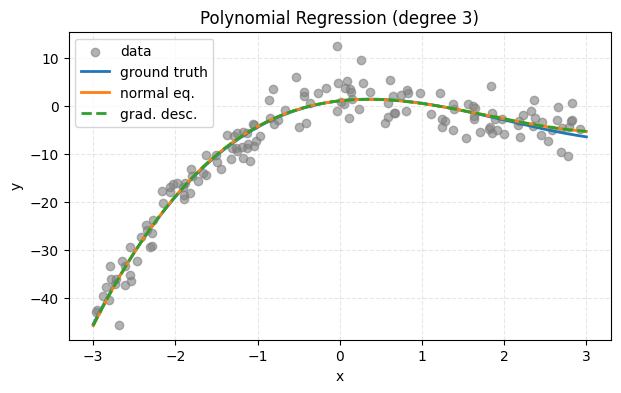

In [6]:
# Create a new figure for the plot
plt.figure(figsize=(7, 4))

# Plot the original noisy data points
plt.scatter(X_raw, y, color='grey', alpha=0.6, label='data')

# Create smooth x values for drawing curves
x_plot = np.linspace(-3, 3, 300).reshape(-1, 1)

# Transform x_plot into polynomial features
X_plot_poly = poly_features(x_plot, DEGREE)

# Predict using normal equation and gradient descent models
y_plot_normal = predict(X_plot_poly, theta_normal)
y_plot_gd     = predict(X_plot_poly, theta_gd)

# Compute the true (noise-free) values from the original cubic function
y_true_plot   = eval_cubic(x_plot)

# Plot the true cubic function (ground truth)
plt.plot(x_plot, y_true_plot, label='ground truth', linewidth=2)

# Plot prediction using normal equation
plt.plot(x_plot, y_plot_normal, label='normal eq.', linewidth=2)

# Plot prediction using gradient descent
plt.plot(x_plot, y_plot_gd, '--', label='grad. desc.', linewidth=2)

# Add axis labels, title, legend, and grid
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Regression (degree 3)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

# Show the plot
plt.show()


### 8. Over‑ vs Under‑fitting quick look

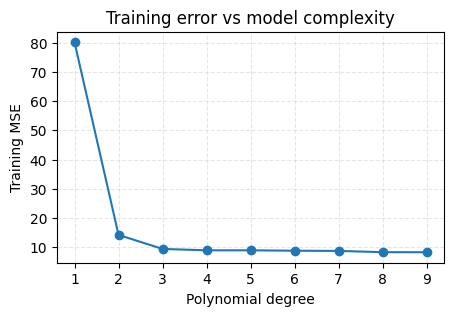

In [7]:

degrees = range(1, 10)
train_errors = []

for d in degrees:
    X_d = poly_features(X_raw, d)
    theta_d = np.linalg.inv(X_d.T @ X_d) @ X_d.T @ y
    train_errors.append(mse(theta_d, X_d, y))

plt.figure(figsize=(5,3))
plt.plot(degrees, train_errors, marker='o')
plt.xlabel('Polynomial degree')
plt.ylabel('Training MSE')
plt.title('Training error vs model complexity')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


### 9. Next steps

* **Regularisation (Ridge / Lasso)** – combat high‑degree over‑fitting.  
* **Feature scaling** – large powers of \(x\) grow quickly; scale or standardise inputs.  
* **Multivariate polynomial regression** – include cross‑terms \(x_1 x_2\) etc.  
* **Basis functions** – replace powers with other non‑linear mappings (splines, RBFs…).
